In [24]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp 
import numpy as np

import jax_cosmo as jc
import jax_cosmo.constants as constants
import astropy.units as u
from jax_lensing.inversion import ks93, ks93inv

from jax.scipy.ndimage import map_coordinates
from scipy.stats import gengamma

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [25]:
field_size = 5                  # Size of the lensing field in degrees
field_npix = 75                # Number of pixels in the lensing field
plane_res = 64

resolution = (60 * field_size) / field_npix
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

source_density = 4 * 16
num_bins = 19

shape_sigma = 0.035

# Defining the coordinate grid for lensing map
xgrid, ygrid = jnp.meshgrid(jnp.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           jnp.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = jnp.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

# Cosmology 
cosmology = jc.Planck15(Omega_c=0.2589, sigma8=0.8159)

# lensplanes = jnp.load('../pm0_lensplanes.npy', allow_pickle=True)
planes_interp = jnp.load('../pm0_lin.npy', allow_pickle=True)

In [26]:
def sample_photoz(num_samples, lb, ub, random_seed=0): 
    # Sample galaxy locations from generalized gamma distribution. 

    a = 2
    c = 1.5
    scale = (1/1.4)

    rv = gengamma(a, c, scale=scale)

    # Depending on the bounds, may have to change size to be larger
    samples = rv.rvs(size=2*num_samples, random_state=random_seed)
    samples = samples[(samples>lb) & (samples<ub)]

    return samples[:num_samples]

def convergence_Born(cosmo,
                     density_planes,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use 
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0
  Qs = []
  ims = []
  im_dicts = []

  for entry in density_planes:
    r = entry['r']; a = entry['a']; p = entry['plane']
    dx = entry['dx']; dz = entry['dz']
    # Normalize density planes
    density_normalization = dz * r / a

    foo = coords * r / dx - 0.5
    coords_in = foo + ((plane_res - 1 - foo.max()) / 2)

    # Interpolate at the density plane coordinates
    im = map_coordinates((p - p.mean()) / p.mean() , 
                         coords_in, 
                         order=1, mode="wrap")
    
    im2 = map_coordinates(p, 
                         coords_in, 
                         order=1, mode="wrap")
    
    convergence += im * constant_factor * density_normalization * jnp.clip(1. - (r / r_s), 0, 1000).reshape([-1, 1, 1])
    Qs.append(constant_factor * density_normalization * jnp.clip(1. - (r / r_s), 0, 1000))
    ims.append(im)

    im_dict = entry
    im_dict['plane'] = im 
    im_dict['coords'] = coords_in
    im_dicts.append(im_dict)

  return np.array(convergence), np.array(Qs).T, np.array(ims), im_dicts

def convergence_Born_2(cosmo,
                     density_planes,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use 
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0
  Qs = []
  ims = []
  im_dicts = []

  for entry in density_planes:
    r = entry['r']; a = entry['a']; p = entry['plane']
    dx = entry['dx']; dz = entry['dz']
    # Normalize density planes
    density_normalization = dz * r / a

    foo = coords * r / dx - 0.5
    coords_in = foo + ((plane_res - 1 - foo.max()) / 2)

    im = p
    
    convergence += im * constant_factor * density_normalization * jnp.clip(1. - (r / r_s), 0, 1000).reshape([-1, 1, 1])
    Qs.append(constant_factor * density_normalization * jnp.clip(1. - (r / r_s), 0, 1000))
    ims.append(im)

    im_dict = entry
    im_dict['plane'] = im 
    im_dict['coords'] = coords_in
    im_dicts.append(im_dict)

  return np.array(convergence), np.array(Qs).T, np.array(ims), im_dicts

In [27]:
z_sources = sample_photoz(360000, 0, 2, 1)


bin_counts = np.round((np.bincount((z_sources * 10).astype('int'))) / (field_npix * field_npix))
bin_counts[10] += 1
bin_counts[11] += 1
bin_counts[12] += 1
bin_counts = bin_counts[1:]
print(len(bin_counts))
print(bin_counts.sum())
z_source = np.linspace(0.15, 1.95, num=19)
print(bin_counts)
print(z_source)

19
64.0
[1. 1. 2. 3. 4. 5. 5. 5. 5. 6. 6. 5. 4. 3. 3. 2. 2. 1. 1.]
[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45
 1.55 1.65 1.75 1.85 1.95]


In [28]:
kappa, Q, od, im_dicts = convergence_Born_2(cosmology, planes_interp, coords=jnp.array(c).T.reshape(2,field_npix,field_npix), z_source=z_source)

In [29]:
print(od.min())

-0.5859712831934919


In [30]:
def make_slice_plots_conv(eta_true, res_eta, vmin, vmax, writer, i, title, cmap='inferno'): 
	eta_slice = eta_true.reshape(res_eta, res_eta, 10, -1).mean(3)
	fig, axes = plt.subplots(2, 5, figsize=(28., 10.))
	for j in range(10): 
		k = j % 5
		l = j // 5
		ax = axes[l, k]
		ax.set_xlim([0, res_eta - 1])
		ax.set_ylim([0, res_eta - 1])
		ax.set_title(title+' Field Slice %d'%j)
		heatmap_im = ax.imshow(eta_slice[:, :, j].T, vmin=vmin, vmax=vmax, cmap=cmap)
		plt.colorbar(heatmap_im, ax=ax)
	# plt.savefig(save_dir + 'true_eta_slice.png')
	fig.tight_layout()
	if writer is not None:
		writer.add_figure(title+' Slice Plot', fig, i)
	else: 
		plt.show()
	plt.close()

In [31]:
# jnp.save('../pm0_4arcmin_64_2.npy', im_dicts, allow_pickle=True)

In [32]:
N = jnp.diag(shape_sigma**2 / bin_counts)

In [33]:
print(N.shape)

(19, 19)


In [34]:
print(kappa.shape)
print(od.shape)
print(Q.shape)
print(N.shape)

(19, 75, 75)
(20, 75, 75)
(19, 20)
(19, 19)


In [35]:
def radial_profile(data):
  """
  Compute the radial profile of 2d image
  :param data: 2d image
  :return: radial profile
  """
  center = data.shape[0]/2
  y, x = jnp.indices((data.shape))
  r = jnp.sqrt((x - center)**2 + (y - center)**2)
  r = r.astype('int32')

  tbin = jnp.bincount(r.ravel(), data.ravel())
  nr = jnp.bincount(r.ravel())
  radialprofile = tbin / nr
  return radialprofile

def measure_power_spectrum(map_data):
  """
  measures power 2d data
  :param power: map
  :return: power spectrum
  """
  data_ft = jnp.fft.fft2(map_data) / map_data.shape[0]
  data = jnp.real(data_ft * jnp.conj(data_ft))
  freqs = jnp.fft.fftfreq(field_npix, 1/field_npix)
  x, y = jnp.meshgrid(freqs, freqs)
  r = jnp.sqrt((x)**2 + (y)**2)
  r = r.astype('int32')

  tbin = jnp.bincount(r.ravel(), data.ravel())
  nr = jnp.bincount(r.ravel())
  radialprofile = tbin / nr

  return radialprofile / (2 * jnp.pi)**2

In [36]:
ps = np.array([measure_power_spectrum(od[i]) for i in tqdm(range(len(od)))])

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
shear = jnp.array([ks93inv(kappa[i], jnp.zeros_like(kappa[i])) for i in range(len(kappa))])

In [38]:
print(shear.shape)

(19, 2, 75, 75)


In [39]:
noise_key = jax.random.PRNGKey(0)
noise = jax.random.normal(noise_key, shape=shear.shape) * shape_sigma / jnp.sqrt(bin_counts).reshape(-1, 1, 1, 1)
shear_noisy = shear + noise
g1hat = np.array([np.fft.fft2(shear_noisy[i, 0]) for i in range(num_bins)])
g2hat = np.array([np.fft.fft2(shear_noisy[i, 1]) for i in range(num_bins)])

In [40]:
print(ps.shape)
print(shear_noisy.shape)
print(g1hat.shape)
print(g2hat.shape)

(20, 53)
(19, 2, 75, 75)
(19, 75, 75)
(19, 75, 75)


In [41]:
def matrix_stuff(gamma, alpha, S, Q, N):
    foo = Q.T @ jnp.linalg.solve(N, gamma)
    foo2 = Q.T @ jnp.linalg.solve(N, Q) + alpha * jnp.linalg.inv(S)
    foo3 = jnp.linalg.solve(foo2, foo)
    # print(foo.shape)
    # print(foo2.shape)
    # print(foo2)
    # print(foo3)
    return foo3

def norm_fro(arr): 
    return jnp.sqrt(jnp.sum(jnp.square(arr)))

def pearson_cc(vol1, vol2): 
    vol2 = vol2.reshape(vol1.shape)
    return jnp.sum(vol1 * vol2) / (norm_fro(vol1) * norm_fro(vol2))

In [42]:
k1, k2 = np.meshgrid(np.fft.fftfreq(field_npix), np.fft.fftfreq(field_npix))
p1 = k1 * k1 - k2 * k2
p2 = 2 * k1 * k2
k2 = k1 * k1 + k2 * k2
k2[0,0] = 1

In [43]:
freqs = np.fft.fftfreq(field_npix, 1/field_npix)
mi, mj = np.meshgrid(freqs, freqs)
r_arr = jnp.sqrt(((mi)**2 + (mj)**2)).astype('int')
S = np.array([np.diag(ps[:, r]) for r in r_arr.flatten()])
print(S.shape)

(5625, 20, 20)


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

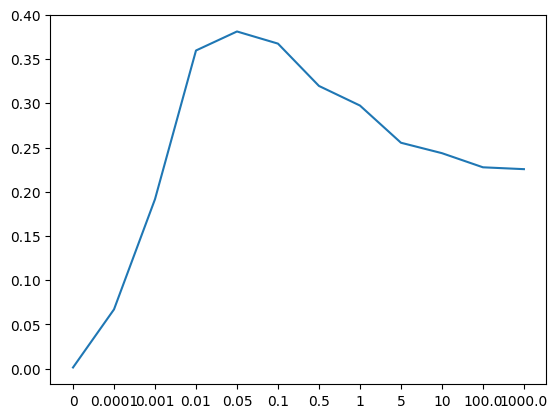

In [44]:
def invert_single(g1hat, g2hat, S, p1, p2, k2, alpha, Q, N):
    g1hat_inv = matrix_stuff(g1hat, alpha, S, Q, N)
    g2hat_inv = matrix_stuff(g2hat, alpha, S, Q, N)
    od_out_E = (p1 * g1hat_inv + p2 * g2hat_inv) / k2
    od_out_B = -(p2 * g1hat_inv - p1 * g2hat_inv) / k2

    return od_out_E, od_out_B

invert_v = jax.vmap(invert_single, in_axes=(1, 1, 0, 0, 0, 0, None, None, None))

alphas = [0, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 1e2, 1e3]
N_scales = [1]
pccs = []

for alpha in tqdm(alphas):
    for N_scale in tqdm(N_scales, leave=False):
        out_E, out_B = invert_v(g1hat.reshape(num_bins, -1), 
                                g2hat.reshape(num_bins, -1),
                                S,
                                p1.reshape(-1, 1),
                                p2.reshape(-1, 1),
                                k2.reshape(-1, 1), 
                                alpha, 
                                Q, 
                                N* N_scale)
        recon_E = np.array([np.fft.ifft2(out_E[...,i].reshape(field_npix, field_npix)).real for i in range(20)])
        pcc = pearson_cc(recon_E, od) 
        pccs.append(pcc)

plt.plot(pccs)
plt.xticks(ticks = np.arange(len(pccs)),labels=alphas)
plt.show()

In [45]:
out_E, out_B = invert_v(g1hat.reshape(num_bins, -1), 
                        g2hat.reshape(num_bins, -1),
                        S,
                        p1.reshape(-1, 1),
                        p2.reshape(-1, 1),
                        k2.reshape(-1, 1), 
                        0.05, 
                        Q, 
                        N)

recon_E = np.array([np.fft.ifft2(out_E[...,i].reshape(field_npix, field_npix)).real for i in range(20)])
ps_recon = np.array([measure_power_spectrum(recon_E[i]) for i in tqdm(range(len(recon_E)))])

  0%|          | 0/20 [00:00<?, ?it/s]

In [46]:
print(pearson_cc(recon_E, od))
print(pearson_cc(recon_E[3:13], od[3:13]))
print(recon_E.shape)
print(od.shape)

0.3812032462012732
0.43228607914189554
(20, 75, 75)
(20, 75, 75)


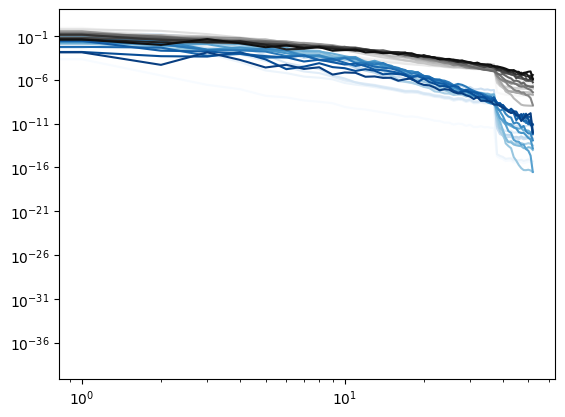

In [23]:
import matplotlib
cmap = matplotlib.colormaps['Greys']
cmap2 = matplotlib.colormaps['Blues']
for i in range(18): 
    plt.loglog(ps[i], color=cmap(i/18))
    plt.loglog(ps_recon[i], color=cmap2(i/18))
# plt.ylim(1e-4, 1e5)
plt.show()

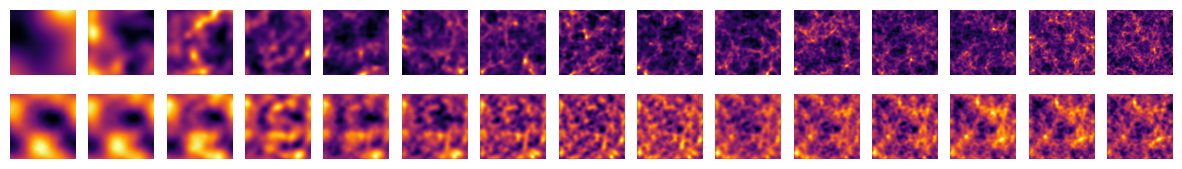

In [24]:
plt.figure(figsize=[15,2])
for i in range(15):
    plt.subplot(2,15,i+1)
    im = plt.imshow(od[i], cmap='inferno')
    # plt.colorbar(im)
    plt.axis('off')

    plt.subplot(2,15,i+1+15)
    im = plt.imshow(np.fft.ifft2(out_E[:, i].reshape(field_npix, field_npix)).real, cmap='inferno')
    # plt.colorbar(im)
    plt.axis('off')

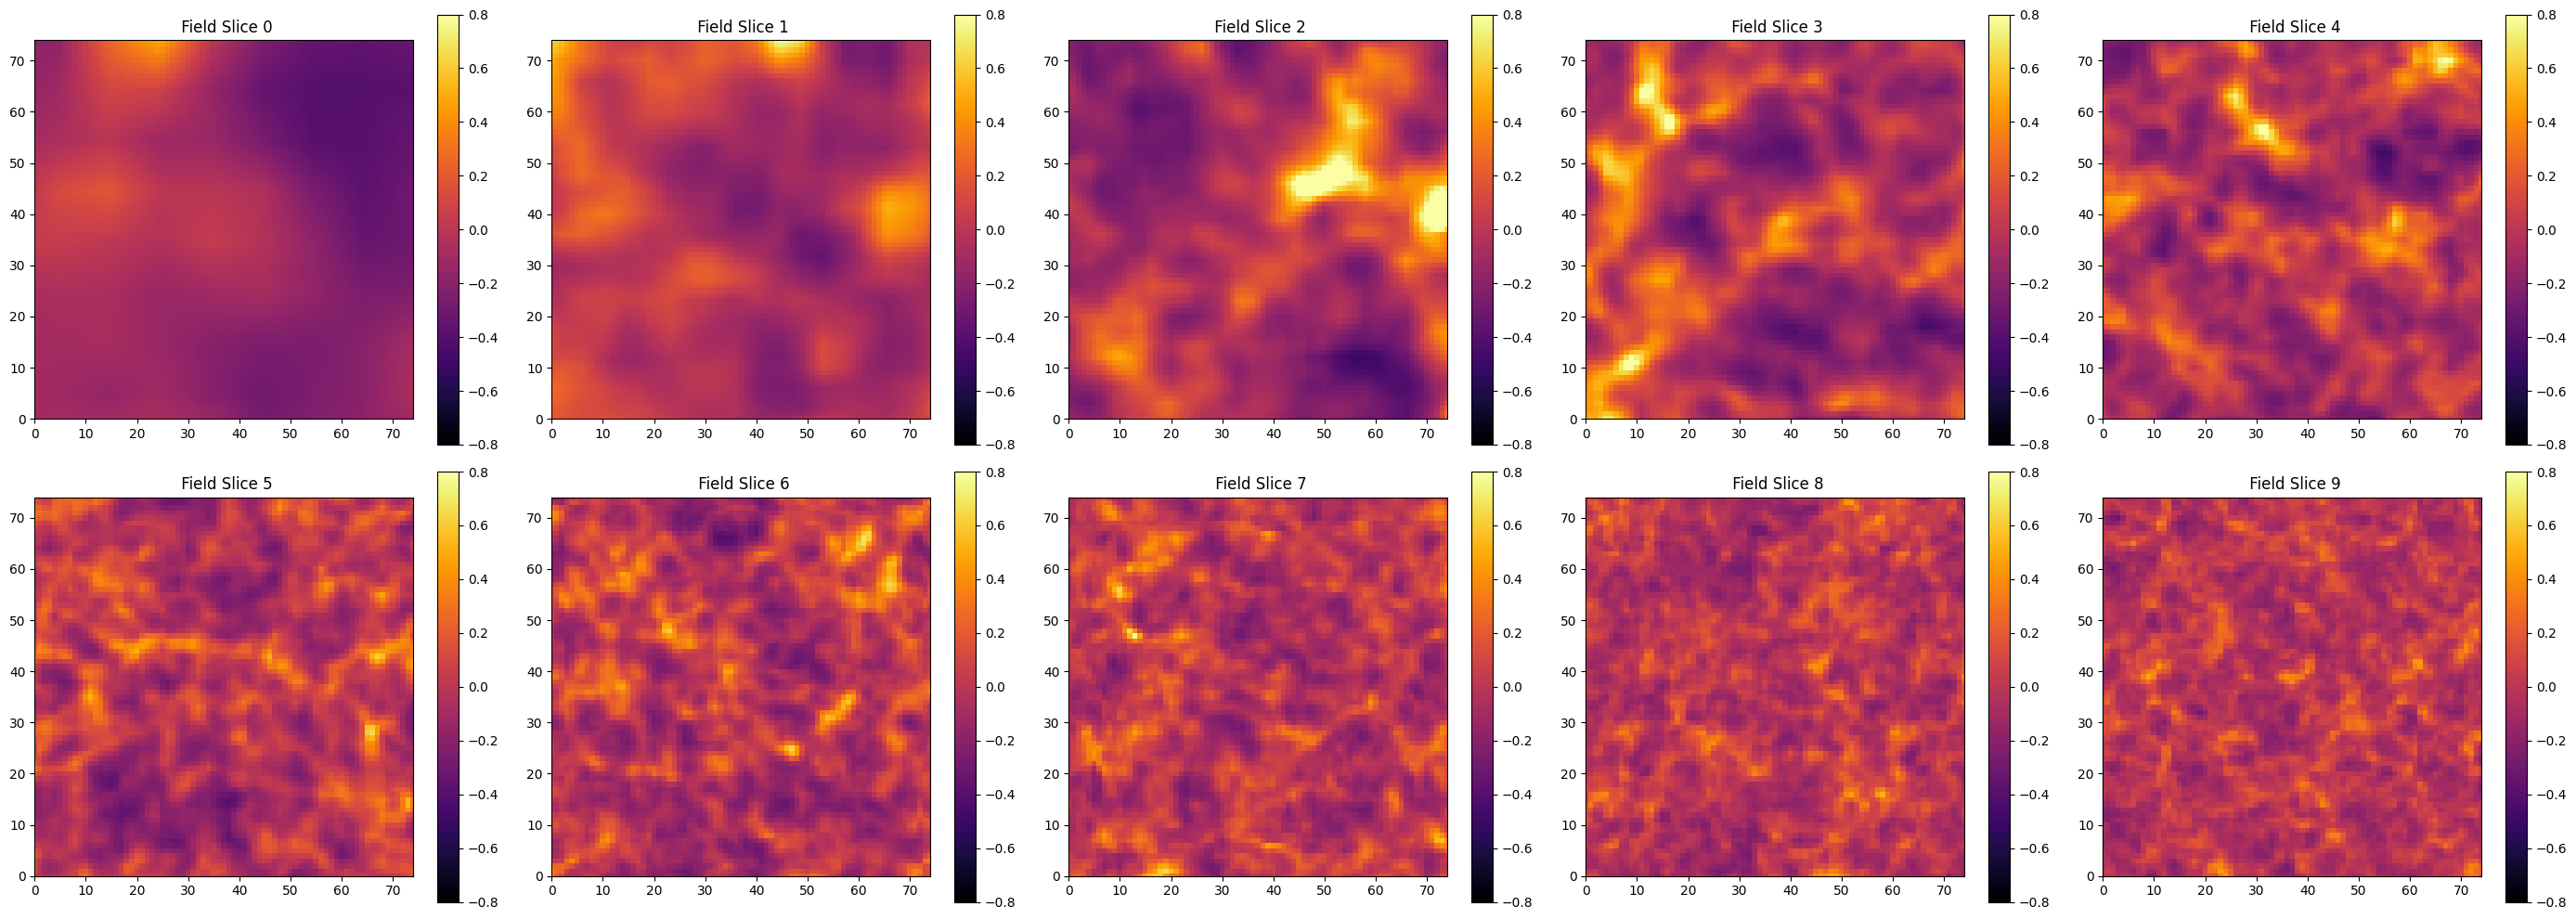

In [47]:
make_slice_plots_conv(np.transpose(od, (1, 2, 0)), 75, -0.8, 0.8, None, 0, '', cmap='inferno')

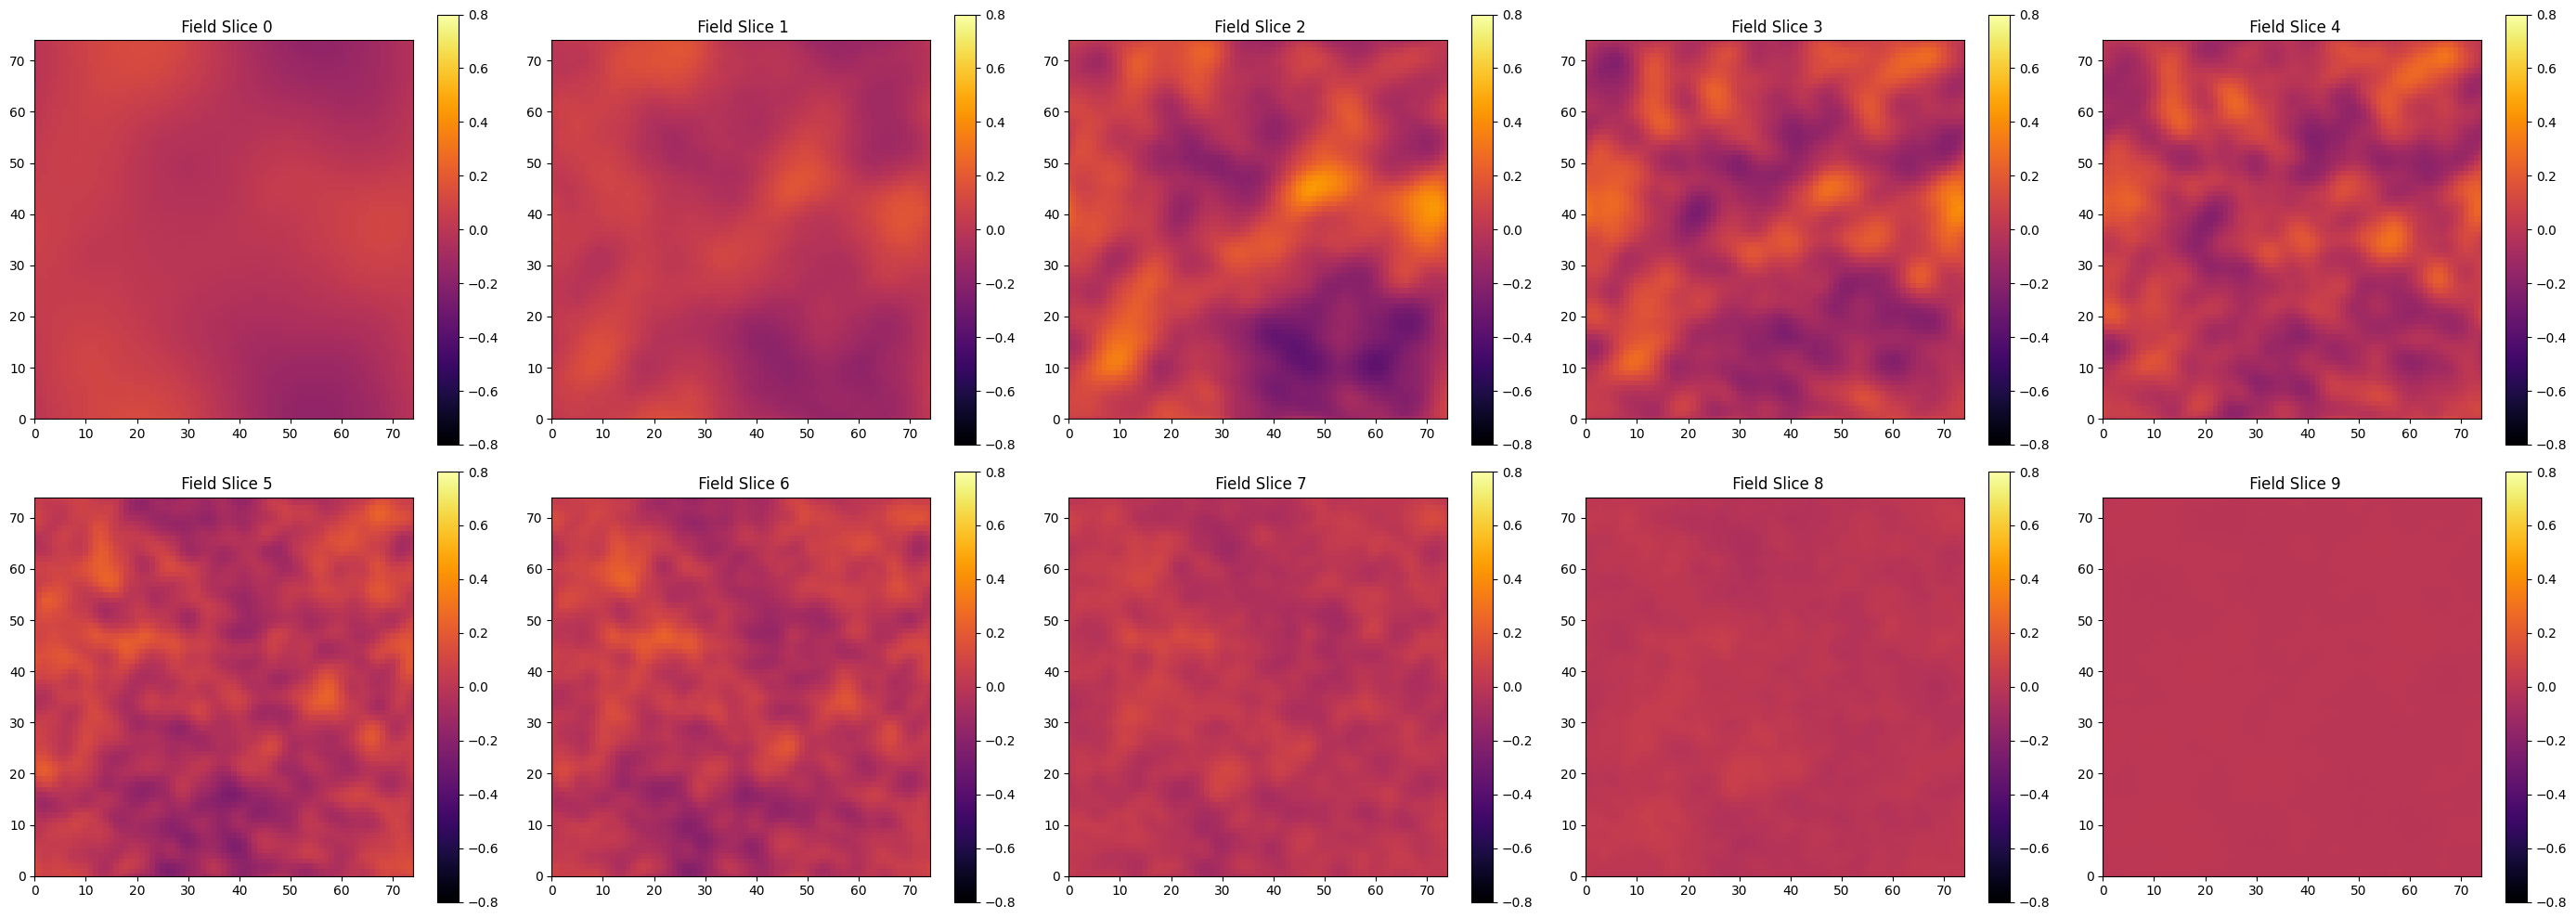

In [48]:
make_slice_plots_conv(np.transpose(recon_E, (1, 2, 0)), 75, -0.8, 0.8, None, 0, '', cmap='inferno')

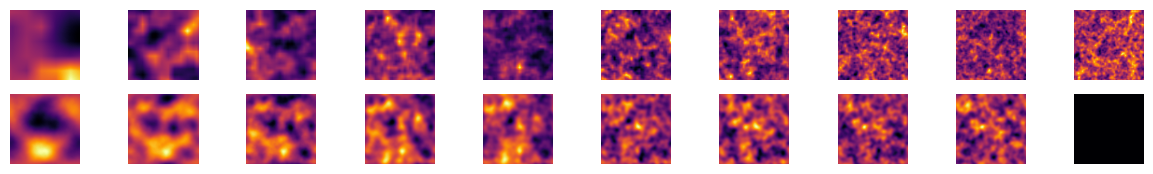

In [44]:
od_half = od.reshape(10, -1, 75, 75).mean(1)
wiener_half = recon_E.reshape(10, -1, 75, 75).mean(1)

plt.figure(figsize=[15,2])
for i in range(10):
    plt.subplot(2,10,i+1)
    im = plt.imshow(od_half[i], cmap='inferno')
    # plt.colorbar(im)
    plt.axis('off')

    plt.subplot(2,10,i+1+10)
    im = plt.imshow(wiener_half[i], cmap='inferno')
    # plt.colorbar(im)
    plt.axis('off')

In [45]:
print(ps.shape)

(20, 53)


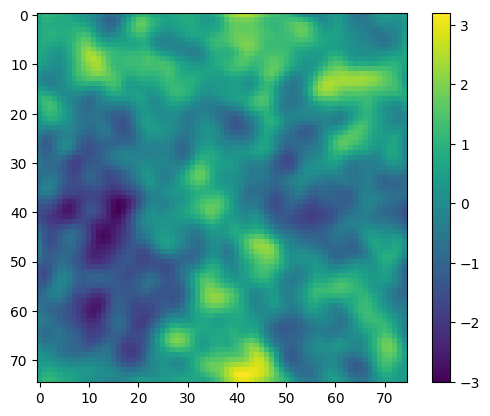

In [49]:
plt.imshow(np.sum(recon_E, axis=0))
plt.colorbar()
plt.show()

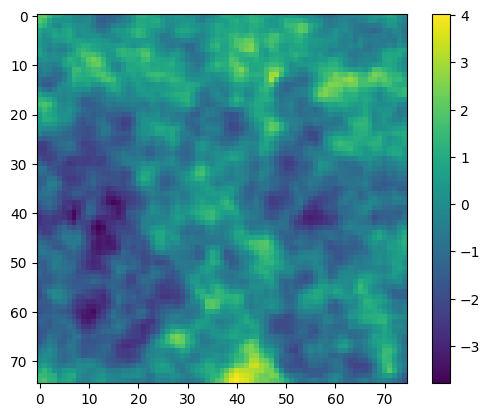

: 

In [50]:
plt.imshow(np.sum(od, axis=0))
plt.colorbar()
plt.show()

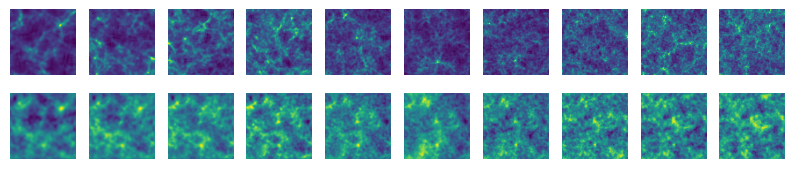

In [348]:
plt.figure(figsize=[10,2])
for i in range(10):
    plt.subplot(2,10,i+1)
    im = plt.imshow(od[3+i])
    plt.axis('off')

    plt.subplot(2,10,i+1+10)
    im = plt.imshow(recon_E[3+i])
    plt.axis('off')